# Face Recognition

---

Ever wonder how hard it is to tell who someone is? 

I have always wanted to try and build a security app that only allows in people that it recognizes. I decided that I wanted to attempt to create a few machine learning models to tackle face recognition. Face recognition can simply be seen as a classification problem, but that requires retraining whenever you want to add someone new into the database. Instead, I am focusing on checking whether or not two pictures are of the same person.

## Table of Contents
* [Getting the Data](#getting_data)
* [Building a Basic Model](#basic_model)
* [Basic Model Results](#basic_model_results)
* [What's The Issue?](#issue)
* [Getting More Data](#more_data)
* [Results with More Data](#more_data_results)
* [What Next?](#what_next)

<a id='getting_data'></a>
## Getting the Data

To start building this model, some form of data is needed to train on. I didn't want to manually collect a ton of images of my friends. Instead, I downloaded the [Labeled Faces in the Wild(LFW) Dataset](http://vis-www.cs.umass.edu/lfw/index.html). This dataset is commonly used in order to test the quality of facial recognition algorithms. Because the model is going to learn whether or not two pictures are of the same person, it should be able to not only recognize these faces, but the face of anyone given a single image of them.

Luckily for me, the dataset is part of the sklearn library. The dataset is quite large and may not run on a lot of hardware. In order to make it work happily on my computer with the model, I saved it to disk as a numpy array. I kept them in color because I believe that skin color can be a important way to tell people apart.

In [1]:
from sklearn.datasets import fetch_lfw_pairs
import numpy as np
from os.path import isfile


if not isfile('lfw_train_pairs.npy') or not isfile('lfw_train_target.npy'): 
    lfw_train = fetch_lfw_pairs(resize=0.8, color=True)
    np.save('lfw_train_pairs', lfw_train.pairs)
    np.save('lfw_train_target', lfw_train.target)
    lfw_train = None
if not isfile('lfw_test_pairs.npy') or not isfile('lfw_test_target.npy'): 
    lfw_test = fetch_lfw_pairs(resize=0.8, color=True, subset='test')
    np.save('lfw_test_pairs', lfw_test.pairs)
    np.save('lfw_test_target', lfw_test.target)
    lfw_test = None

trainX = np.load('lfw_train_pairs.npy', mmap_mode='r')
trainY = np.load('lfw_train_target.npy', mmap_mode='r')
testX = np.load('lfw_test_pairs.npy', mmap_mode='r')
testY = np.load('lfw_test_target.npy', mmap_mode='r')
print(trainX.shape)
print(testX.shape)

(2200, 2, 100, 75, 3)
(1000, 2, 100, 75, 3)


In order to check that the data downloaded well and to get a better idea of what the images look like, I am displaying 5 images from the dataset.

Using TensorFlow backend.


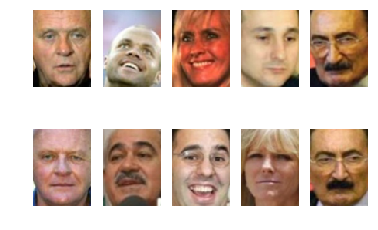

In [2]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img
from random import randint

for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    r = randint(0, trainX.shape[0]-1)
    plt.imshow(array_to_img(trainX[r,0]))
    plt.subplot(2, 5, i+6)
    plt.axis('off')
    plt.imshow(array_to_img(trainX[r,1]))

plt.show()

<a id='basic_model'></a>
## Building a Basic Model

To start off, I am going to use a rather easy to implement model. I am going to run both images through a convolutional neural network and then compare the results with a fully connected layer. I will be using a pretrained InceptionV3 as the core for image processing. In Keras, InceptionV3 will take as input images larger than 139 by 139 and smaller than 300 by 300 and output a vector of numbers related to the image.

Here is how the basic processing will look:
    1. 2 Images as input
    2. Images processed separately through InceptionV3
    3. Output tensors for both images are then concatenated together
    4. Data is run through fully connected layer
    5. Output of whether the images are of the same face(1) or not(0)
 It is important to note that InceptionV3 is already trained and its weights should not be modified.

In [3]:
from keras.layers import Input, concatenate, GlobalAveragePooling2D, Dense, Dropout, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import Xception
from keras.applications.xception import preprocess_input

def compile_model():

    input1 = Input(shape=trainX.shape[2:])
    input2 = Input(shape=trainX.shape[2:])
    
    preprocess1 = Lambda(lambda x: preprocess_input(x))(input1)
    preprocess2 = Lambda(lambda x: preprocess_input(x))(input2)
    #Load two Inception nets
    cnn1 = Xception(include_top=False, pooling='avg', input_tensor=preprocess1)
    cnn2 = Xception(include_top=False, pooling='avg', input_tensor=preprocess2)

    #Stop training exept for the last few layers
    #:-27
    for layer in cnn1.layers:
        layer.trainable = False
    for layer in cnn2.layers:
        layer.trainable = False
        
    #Rename layers to stop conflicts
    for layer in cnn2.layers:
        layer.name = layer.name + '-1'

    #add fully conneced layers
    x = concatenate([cnn1.output, cnn2.output], axis=1)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)

    #compile model
    model = Model([input1, input2], out)
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
base_model = compile_model()
#print(base_model.summary())

This model is actually quite a large one. Using two copies of Xception net means that this model has over 40 million parameters. Luckily, only the last 2 million of the parameters are necessary to train and that greatly increases training speed. 

Now that the model is compiled, it is time to fit the model to the data and see how it does against the validation set.

In [4]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from os import listdir
from os.path import isfile, join
import pickle

files = [f for f in listdir('base_model') if isfile(join('base_model', f))]
if len(files) > 1:
    base_history = pickle.load(open("base_model/history.p", "rb"))
else:
    filepath="base_model/weights-best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    tensorboard = TensorBoard(log_dir="logs/base_model")
    callbacks_list = [checkpoint, tensorboard]#, early_stopping]

    base_history = base_model.fit([trainX[:,0,:,:],trainX[:,1,:,:]],
              trainY, validation_data=([testX[:,0,:,:],testX[:,1,:,:]],testY),
              epochs=50, batch_size=64, callbacks=callbacks_list, verbose=0).history
    pickle.dump(base_history, open("base_model/history.p", "wb+"))

<a id='basic_model_results'></a>
## Basic Model Results
The training is complete, but just looking at numbers is not the best way to tell how good a model is doing. In order to better understand the model, here are some graphs of the accuracy as it trained.

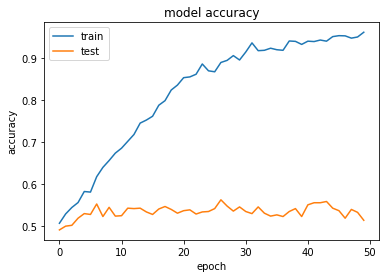

In [5]:
# summarize history for accuracy
plt.plot(base_history['acc'])
plt.plot(base_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model learned the training data very well, but failed to really learn the testing data. The training accuracy manage to climb during all of training, but the validation barely managed to go above 50%. For further testing of the model, the best version of the model according to the validation set is used.

In [6]:
base_model.load_weights('base_model/weights-best.hdf5') #Load best epoch model

Another important metric for binary classifiers is their ROC curve and the area under it. Here is the ROC and AUC.

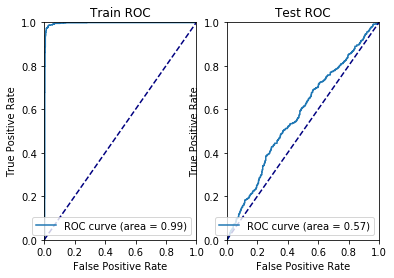

In [7]:
from sklearn.metrics import auc, roc_curve

y_pred = base_model.predict([trainX[:,0,:,:],trainX[:,1,:,:]])

fpr, tpr, _ = roc_curve(trainY, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

y_pred = base_model.predict([testX[:,0,:,:],testX[:,1,:,:]])

fpr, tpr, _ = roc_curve(testY, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()

<a id='issue'></a>
## What's the Issue?
As is sadly shown by the results, the model is extremely overfitting. It has a near perfect training accuracy and ROC AUC, but is only slightly better than random guessing on the training set. I think the main issue is that I only have 2200 training examples. For models like Facenet and Deepface, millions of images are used for training. In order to check if the model would benefit from more data, it is useful to graph the training and validation accuracy based off of the number of training samples.

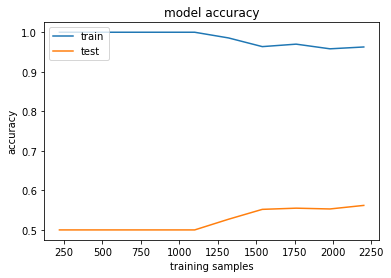

In [8]:
import pickle
from os.path import isfile
from keras import backend as K
import gc
from time import time

#clear base model from memory
base_model = None
K.clear_session()
gc.collect()

if not isfile('train_acc.p') or not isfile('val_acc.p') or not isfile('samples.p') or not isfile('numpoints.p'):
    numPoints = 10
    pickle.dump(numPoints, open('numpoints.p', 'wb+'))
    train_acc = []
    val_acc = []
    samples = []
else:
    numPoints = pickle.load(open('numpoints.p', 'rb'))
    train_acc = pickle.load(open('train_acc.p', 'rb'))
    val_acc = pickle.load(open('val_acc.p', 'rb'))
    samples = pickle.load(open('samples.p', 'rb'))

if(len(train_acc) < numPoints):
    #print('Starting at iteration '+str(len(train_acc)+1)+' out of '+str(numPoints))
    for i in range(len(train_acc), numPoints-1):
        start = time()
        numSamples = int(trainX.shape[0]*(i+1.0)/numPoints)
        samples.append(numSamples)
        X = trainX[:numSamples,:,:,:]
        y = trainY[:numSamples]
        temp_model = compile_model()
        history = temp_model.fit([X[:,0,:,:],X[:,1,:,:]],y, 
                       validation_data=([testX[:,0,:,:],testX[:,1,:,:]],testY),
                       epochs=50, batch_size=64, verbose=0, 
                        callbacks=[TensorBoard(log_dir="logs/base_model_"+str(numSamples))]).history
        train_acc.append(max(history['acc']))
        val_acc.append(max(history['val_acc']))
        temp_model = None
        K.clear_session()
        gc.collect()
        pickle.dump(train_acc, open('train_acc.p', 'wb+'))
        pickle.dump(val_acc, open('val_acc.p', 'wb+'))
        pickle.dump(samples, open('samples.p', 'wb+'))
        #print('Model '+str(i+1)+': ('+str(train_acc[-1])+', '+str(val_acc[-1])+') in '+str(time()-start)+' seconds')
    samples.append(trainX.shape[0])
    train_acc.append(max(base_history['acc']))
    val_acc.append(max(base_history['val_acc']))
    pickle.dump(train_acc, open('train_acc.p', 'wb+'))
    pickle.dump(val_acc, open('val_acc.p', 'wb+'))
    pickle.dump(samples, open('samples.p', 'wb+'))
    
plt.plot(samples, train_acc)
plt.plot(samples, val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('training samples')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The basic idea of a accuracy vs number of training samples graph is to show if more data will help the model learn. If a model is overfitting to the training data and could use more data to assist in learning, there will be a large gap between the two line(that is the case show here). If the model would not learn better with more data, the train and test accuracy will either converge(if the result is lower than you want than you need to redesign the model or train for more epochs) or flat line(the model is unable to learn no matter how much data it is given)

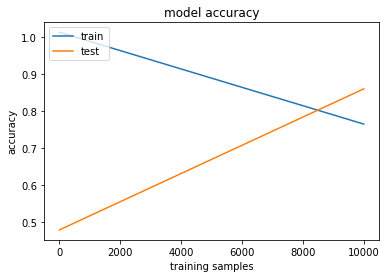

In [9]:
trainline = np.poly1d(np.polyfit(samples, train_acc, 1))
valline = np.poly1d(np.polyfit(samples, val_acc, 1))
x = np.linspace(0, 10000, 100)
plt.plot(x, trainline(x))
plt.plot(x, valline(x))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('training samples')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The lines shown above are a linear projections of what the training and validation accuracy might look like with more data. In reality, the accuracy would not increase linearly but would increase logirthmically. If I wanted to build a strong model, I would probably need at least 10,000 examples, but 100,000 would be a much safer number.

<a id='more_data'></a>
## Getting More Data

In order to get more data, I downloaded the [MegaFace](http://megaface.cs.washington.edu/) dataset. I downloaded the tightly cropped images because they are most similar to the LFW dataset. The dataset is extracted and saved in the MegafaceIdentities_VGG folder. The dataset is organized with one identity in each subfolder. In order to use these images for face verification, the data needs to be paired and resized. Because the dataset is extremely large, I am only going to load 100,000 samples.

Every person has at least 3 images. For each person, I will load 3 positive verification examples and 3 negative verification examples. The negative examples will be made off of the next 3 identities in the list because they are shuffled already.

In [10]:
from os import listdir
from scipy.misc import imread, imresize
from sklearn.utils import shuffle

if not isfile('megafaceX.npy') or not isfile('megafaceY.npy'):
    imsize = (trainX.shape[2], trainX.shape[3])
    megafaceX = np.memmap('megafaceX.npy', dtype='float32', mode='w+', shape=(100000, trainX.shape[1], trainX.shape[2], trainX.shape[3], trainX.shape[4]))
    megafaceY = np.memmap('megafaceY.npy', dtype='float32', mode='w+', shape=(100000))
    identities = listdir('MegafaceIdentities_VGG')
    current_identity = 0
    current_sample = 0
    #shuffle data as it is loaded
    shuffle = np.arange(megafaceX.shape[0])
    np.random.shuffle(shuffle)
    for i, s in enumerate(shuffle):
        #load and resize image 3 positive and 3 negative per identity
        if current_sample == 0:
            img0 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[0]
            img1 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[1]
            megafaceY[s] = 1
        elif current_sample == 1:
            img0 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[0]
            img1 = 'MegafaceIdentities_VGG/'+identities[current_identity+1]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity+1])[0]
            megafaceY[s] = 0
        elif current_sample == 2:
            img0 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[1]
            img1 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[2]
            megafaceY[s] = 1
        elif current_sample == 3:
            img0 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[1]
            img1 = 'MegafaceIdentities_VGG/'+identities[current_identity+2]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity+2])[1]
            megafaceY[s] = 0
        elif current_sample == 4:
            img0 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[0]
            img1 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[2]
            megafaceY[s] = 1
        elif current_sample == 5:
            img0 = 'MegafaceIdentities_VGG/'+identities[current_identity]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity])[2]
            img1 = 'MegafaceIdentities_VGG/'+identities[current_identity+3]+"/"+listdir('MegafaceIdentities_VGG/'+identities[current_identity+3])[2]
            megafaceY[s] = 0
            current_identity += 1
            current_sample = -1
        megafaceX[s][0] = imresize(imread(img0), imsize)
        megafaceX[s][1] = imresize(imread(img1), imsize)
        current_sample += 1 
        #if i % 1000 == 0:
        #    print("%d%%"%(i/1000))
    
    megafaceX.flush()
    megafaceY.flush()

megafaceX = np.memmap('megafaceX.npy', dtype='float32', mode='r', shape=(100000, trainX.shape[1], trainX.shape[2], trainX.shape[3], trainX.shape[4]))
megafaceY = np.memmap('megafaceY.npy', dtype='float32', mode='r', shape=(100000))

Just like before, I am displaying some random examples in order to insure the data loaded well.

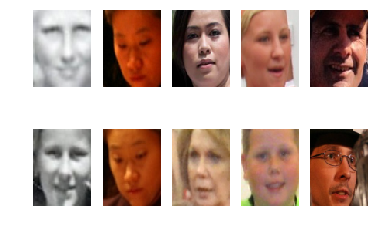

In [11]:
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    r = randint(0, megafaceX.shape[0]-1)
    plt.imshow(array_to_img(megafaceX[r,0]))
    plt.subplot(2, 5, i+6)
    plt.axis('off')
    plt.imshow(array_to_img(megafaceX[r,1]))

plt.show()

This time, there is not a set validation set. Instead, 30% of the training data will be used specifically for validation. Because I do not have an extremely powerful server, I am only going to using 100,000 samples. This leads to training on about 30 times the data as the basic model. Hopefully, this will be enough to create siginificant improvement.

In [12]:
more_data_model = compile_model()

files = [f for f in listdir('more_data_model') if isfile(join('more_data_model', f))]
if len(files) > 1:
    more_data_history = pickle.load(open("more_data_model/history.p", "rb"))
else:
    filepath="'more_data_model/weights-best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    tensorboard = TensorBoard(log_dir="logs/more_data_model")
    callbacks_list = [checkpoint, tensorboard]

    more_data_history = more_data_model.fit([megafaceX[:,0,:,:],megafaceX[:,1,:,:]],
              megafaceY[:], validation_split=0.3,
              epochs=50, batch_size=64, callbacks=callbacks_list, verbose=0).history
    pickle.dump(more_data_history, open("more_data_model/history.p", "wb+"))

<a id='more_data_results'></a>
## Results with More Data

As with before, I am going to show the same graphs as before except with the new model.

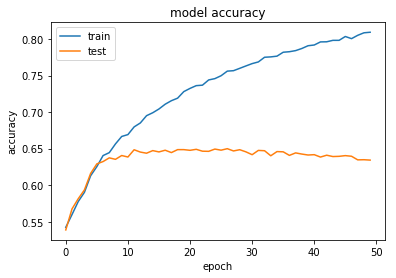

In [13]:
# summarize history for accuracy
plt.plot(more_data_history['acc'])
plt.plot(more_data_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

By training on the 100,000 samples the validation accuracy increased from just over 50% to just under 65%. This is a huge increase. Even with 100,000 samples, the network is still clearly overfitting after about the 10th epoch. Though adding even more data would have diminishing returns, this model would probably still gain significant improvements if it had hundreds of thousands or millions of more samples.

Let's visualize the ROC curve again in order to confirm the models is learning.

In [14]:
more_data_model.load_weights('more_data_model/weights-best.hdf5') #Load best epoch model

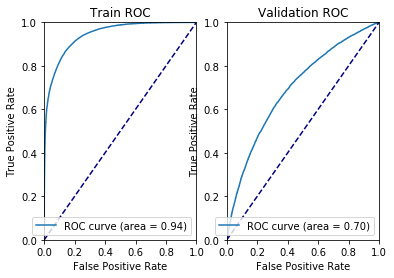

In [15]:
y_pred = more_data_model.predict([megafaceX[:70000,0,:,:],megafaceX[:70000,1,:,:]])

fpr, tpr, _ = roc_curve(megafaceY[:70000], y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

y_pred = more_data_model.predict([megafaceX[70000:,0,:,:],megafaceX[70000:,1,:,:]])

fpr, tpr, _ = roc_curve(megafaceY[70000:], y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")
plt.show()

The lower AUC on the training data and the higher AUC on the test data clearly shows that the model is generalizing better and not overfitting as much. The model is definitely doing well on the MegaFace data, but how does it do on the initial LFW validation set?

Accuracy: 60%


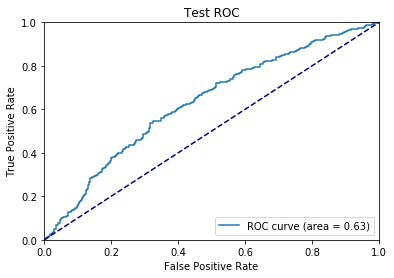

In [16]:
from sklearn.metrics import accuracy_score
y_pred = more_data_model.predict([testX[:,0,:,:],testX[:,1,:,:]])

print("Accuracy: %d%%" % int(100*accuracy_score(testY, np.around(y_pred))))

fpr, tpr, _ = roc_curve(testY, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()

Though the gains are not as substantial, the model is definitely better at the LFW challenge now that it has external training data.

<a id='what_next'></a>
## What Next?

Even with training this model on more data, it is not anywhere near reliable enough to use for a face verification security system. What could still be done to make it better?

* More Training Data - If all of the MegaFace dataset was used to create data as was done above, instead of just having 100,000 samples, their would be over 3 million samples. That is almost 1000 times the initial amount of data.
* Reduce Overfitting through:
    * Higher Dropout
    * L1 and L2 Regulatization
    * Batch Normalization
    * Different Network Architecture
* Xception Net Weight Tuning - After training for a while, it might be useful to fine tune the xception net weights by making them trainable again. After fine tuning, the convolutional layers would be better at telling faves apart.
* Better Network Technique - This model was made in a very simple and memory heavy way with two Xception nets. In reality, it is much better to train one network that embeds each image into a small vector and then use euclidian distance to tell people apart. With a better technique, the model would be able to learn faster and on far fewer samples. In fact, it would probably be best to follow the example of [Facenet](https://arxiv.org/abs/1503.03832v3) with triplet loss.

This model is a very basic one that shows a good proof of concept. The model may not be state of the art, but it is still capable of learning. Through it may not be good for security, it could still make a fun app to allow face comparison.